In [2]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime

In [3]:
def to_unix_time(dt):
    epoch = datetime.utcfromtimestamp(0)
    return (dt - epoch).total_seconds() * 1000

total number of lines = 144281
number of lines removed =  0 ( 0 %)


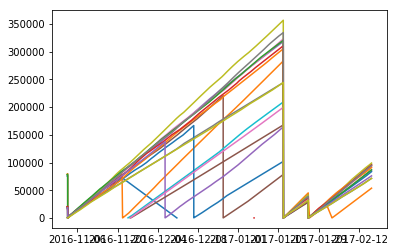

In [38]:
df = pd.read_csv("../data/hr_device.csv")

print "total number of lines =", len(df)

excluded_macs = ["00-17-0d-00-00-58-f8-63",
                 "00-17-0d-00-00-58-f8-78",
                 "00-17-0d-00-00-58-eb-69",]

df_clean = df#[~df.mac.isin(excluded_macs)]

lines_removed = len(df) - len(df_clean)
print "number of lines removed = ", lines_removed, "(", lines_removed*100/len(df), "%)"

df_clean.loc[:, "date"] = pd.to_datetime(df_clean.time, unit='s')
df_clean.set_index(df_clean["date"], inplace=True)
df_clean.head()

for name, group in df_clean.groupby(["mac"]):
    plt.plot(group.index, group.charge, label=name)
#plt.legend()

# Cleaning Charge


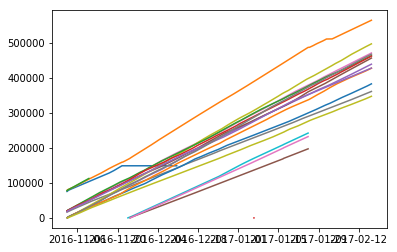

In [39]:
grouped = df_clean.groupby(["mac"])
charge_clean = []

for name, group in grouped:
    prev_charge = 0
    new_charge = 0
    charge_max = 0
    for curr_charge in group.charge:
        if curr_charge < prev_charge:
            new_charge += curr_charge
        else:
            new_charge += (curr_charge - prev_charge)
        charge_clean.append(new_charge)
        prev_charge = curr_charge

df_clean.loc[:, "charge_clean"] = pd.Series(charge_clean, index=df_clean.date)

for name, group in df_clean.groupby(["mac"]):
    plt.plot(group.index, group.charge_clean, label=name)

#plt.legend()
plt.show()

In [41]:
grouped = df_clean.groupby(["mac"])
stats = []
charge_tot = 2200 * 3600 # charge total in mC assuming 2200mAh battery

for name, group in grouped:    
    time_diff = group.time[len(group.time)-1] - group.time[0]
    if time_diff > 3600*24*30*3:
        charge_max = group.charge_clean.max()
        charge_left = charge_tot - charge_max
        time_left = charge_tot * time_diff / charge_max
        stats.append([name[-8:],
                      "{:,} C".format(charge_max) + " ({0}%) ".format(round(100*float(charge_max)/charge_tot, 1)),
                      "{0} years".format(int(time_left/3600/24/365))])
    
print pd.DataFrame(stats, columns=["MAC", "charge consumed", "lifetime"])\
    .set_index("MAC")\
    .to_latex(column_format="|c|c|c|")

\begin{tabular}{|c|c|c|}
\toprule
{} &    charge consumed & lifetime \\
MAC      &                    &          \\
\midrule
38-03-dd &  565,552 C (7.1\%)  &  4 years \\
58-e9-ca &  439,811 C (5.6\%)  &  5 years \\
58-e9-cb &  457,318 C (5.8\%)  &  5 years \\
58-eb-5b &  471,838 C (6.0\%)  &  4 years \\
58-eb-64 &  361,830 C (4.6\%)  &  6 years \\
58-eb-67 &  497,978 C (6.3\%)  &  4 years \\
58-f3-17 &  383,552 C (4.8\%)  &  5 years \\
58-f4-f8 &  428,316 C (5.4\%)  &  5 years \\
58-f5-23 &  464,164 C (5.9\%)  &  4 years \\
58-f5-3c &  463,003 C (5.8\%)  &  4 years \\
58-f5-58 &  428,718 C (5.4\%)  &  5 years \\
58-f8-8f &  468,257 C (5.9\%)  &  4 years \\
58-f9-c4 &  347,970 C (4.4\%)  &  6 years \\
\bottomrule
\end{tabular}

